# Lab 2 - Metrics and evaluation

Created by : Alexandre Bruckert / University of Nantes - alexandre.bruckert@univ-nantes.fr

Date : 2024

Inspired by the work of Bylinzkii et. al., *What do different evaluation metrics tell us about saliency models ?*, IEEE PAMI, 41(3), 2018

In this lab, we will learn how to compare visual saliency maps together, and more generally a few keys to quantify visual attention data.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.ndimage.filters import gaussian_filter
#import cv2

C:\Users\Marie\AppData\Local\Temp\ipykernel_16928\2630330708.py:5: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


First, we will need a function to draw 2-dimensional Gaussian distributions

In [2]:
def create_examples(img_size, sigma_filter, locations, values):
    img = np.zeros((img_size, img_size))
    for loc, val in zip(locations, values):
        img[loc[0], loc[1]] = val
    img = gaussian_filter(img, sigma=sigma_filter)
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    return img

Now, we will evaluate the impact of several modifications in dummy saliency maps, to understand the way the metrics work. To do so, we will create two ground truth images : one with a single Gaussian point, and one with two.

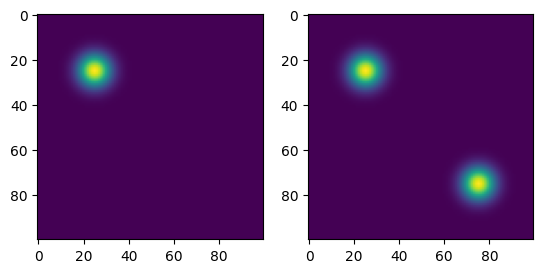

In [3]:
gt1 = create_examples(100, 5, [[25, 25]], [1])
gt2 = create_examples(100, 5, [[25, 25], [75, 75]], [1, 1])

f, axarr = plt.subplots(1,2)
axarr[0].imshow(gt1)
axarr[1].imshow(gt2)

plt.show()

With the first ground-truth, we will evaluate the impact of the variance of the prediction, as well as the location of the prediction.

We will also create a "fixation ground-truth", with just a single (or two) fixation point at the center of the cluster(s)

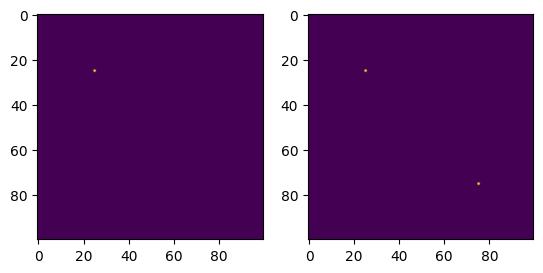

In [4]:
gt_fix_1 = np.zeros((100, 100))
gt_fix_1[25,25] = 1
gt_fix_2 = np.zeros((100, 100))
gt_fix_2[25,25] = 1
gt_fix_2[75,75] = 1

f, axarr = plt.subplots(1,2)
axarr[0].imshow(gt_fix_1)
axarr[1].imshow(gt_fix_2)

plt.show()

Now, let's define a few util functions

In [5]:
def range_normalize(x):
    """Normalizes x to [0, 1]"""
    x = (x - x.min()) / (x.max() - x.min())
    return x

def sum_normalize(x):
    """Normalizes x so that it sums to 1"""
    return x / x.sum()


def std_normalize(x):
    return (x - np.mean(x)) / np.std(x)

def log_density(saliencyMap, eps=np.spacing(1.0)):
    """Transforms a non probabilistic saliency map into a log density for
    further metric computation.

    Arguments:
        saliencyMap: Grayscale saliency map.
    """
    saliencyMap = saliencyMap - saliencyMap.min()
    saliencyMap += eps
    saliencyMap /= saliencyMap.sum()
    return np.log(saliencyMap)

And now, the metrics !

In [6]:
def AUC_Borji(saliencyMap, fixationMap, Nsplits=100, stepSize=0.1):
    """
    This measures how well the saliencyMap of an image predicts the ground
    truth human fixations on the image.

    ROC curve created by sweeping through threshold values at fixed step size
    until the maximum saliency map value.
    True positive (tp) rate corresponds to the ratio of saliency values
    above threshold at fixation locations to the total number of fixation
    locations.
    False positive (fp) rate corresponds to the ratio of saliency map
    values above threshold at random locations to the total number of random
    locations (as many random locations as fixations, sampled uniformly from
    ALL IMAGE PIXELS), averaging over Nsplits number of selections of
    random locations.

    :param saliencyMap: numpy array, saliency map
    :param fixationMap: numpy array, fixation map (binary matrix)
    :param Nsplits: int, number of random splits
    :param stepSize: float, size of the step for sweeping through saliency map

    :return score: float, AUC Borji score
    :return fpr: float, false positive rate
    :return tpr: float, true positive rate
    """
    
    saliencyMap = range_normalize(saliencyMap)

    S = saliencyMap.flatten()
    F = fixationMap.flatten()

    Sth = S[F > 0]  # saliency map values at fixation locations
    Nfixations = len(Sth)
    Npixels = len(S)

    # For each fixation, sample Nsplits values from anywhere on the saliency map
    r = np.random.randint(1, Npixels, size=Nfixations * Nsplits)
    randfix = S[r[:]]
    randfix = np.reshape(randfix, (Nfixations, Nsplits))

    # Calculate AUC per random split (set of random locations)
    auc = np.empty(Nsplits)
    auc[:] = np.nan
    for s in range(Nsplits):
        curfix = randfix[:, s]
        allthreshes = np.arange(0, np.amax(np.concatenate([Sth, curfix])) + stepSize, stepSize)
        allthreshes = allthreshes[::-1]
        tpr = np.zeros(len(allthreshes) + 2)
        fpr = np.zeros(len(allthreshes) + 2)
        tpr[0], tpr[-1] = 0, 1
        fpr[0], fpr[-1] = 0, 1
        for i in range(len(allthreshes)):
            thresh = allthreshes[i]
            tpr[i + 1] = (Sth >= thresh).sum() / Nfixations
            fpr[i + 1] = (curfix >= thresh).sum() / Nfixations
        auc[s] = np.trapz(tpr, x=fpr)
    # Average across random splits
    score = np.mean(auc)
    return score, fpr, tpr

In [7]:
def AUC_Judd(saliencyMap, fixationMap, jitter=True):
    """
    This measures how well the saliencyMap of an image predicts the ground
    truth human fixations on the image. ROC curve created by sweeping through
    threshold values determined by range of saliency map values at fixation
    locations.
    Uses a uniform non-fixation distribution, i.e. the full saliency map as
    nonfixations.

    created Tilke Judd, Oct 2009
    updated  Zoya Bylinskii, Aug 2014
    python-version by Dario Zanca, Jan 2017

    true positive (tp) rate correspond to the ratio of saliency map values
    above threshold at fixation locations to the total number of fixation
    locations, false positive (fp) rate correspond to the ratio of
    saliency map values above threshold at all other locations to
    the total number of posible other locations (non-fixated image pixels)

    Arguments
    ---------
        saliencyMap: Saliency map image (grayscale)
        fixationMap: Ground truth fixations (binary image)
        jitter: Whether to add tiny non-zero random constant to all map
            locations to ensure ROC can be calculated robustly
            (to avoid uniform region)

    Returns
    -------
        score: float
            AUC value for the given inputs
    """
    if not np.shape(saliencyMap) == np.shape(fixationMap):
        saliencyMap = cv2.resize(saliencyMap, np.shape(fixationMap)[:2][::-1])

    # jitter saliency maps that come from saliency models that have a lot of
    # zero values.
    # If the saliency map is made with a Gaussian then it does not need to be
    # jittered as the values are varied and there is not a large patch of the
    # same value. In fact jittering breaks the ordering in the small values!
    if jitter:
        # jitter the saliency map slightly to disrupt ties of the same numbers
        saliencyMap = saliencyMap + np.random.random(np.shape(saliencyMap)) / 10**7

    saliencyMap = range_normalize(saliencyMap)

    if np.isnan(saliencyMap).all():
        __logger.debug('NaN saliencyMap')
        score = float('nan')
        return score

    S = saliencyMap.flatten()
    F = fixationMap.flatten()

    # Sal map values at fixation locations
    Sth = S[F > 0]
    Nfixations = len(Sth)
    Npixels = len(S)

    # sort sal map values, to sweep through values
    allthreshes = sorted(Sth, reverse=True)

    tpr = np.zeros((Nfixations + 2))
    fpr = np.zeros((Nfixations + 2))
    tpr[0], tpr[-1] = 0, 1
    fpr[0], fpr[-1] = 0, 1

    for i in range(Nfixations):
        thresh = allthreshes[i]
        # total number of sal map values above threshold
        aboveth = (S >= thresh).sum()
        # ratio sal map values at fixation locations above threshold
        tpr[i + 1] = float(i + 1) / Nfixations
        # ratio other sal map values above threshold
        fpr[i + 1] = float(aboveth - i) / (Npixels - Nfixations)

    score = np.trapz(tpr, x=fpr)
    allthreshes = np.insert(allthreshes, 0, 0)
    allthreshes = np.append(allthreshes, 1)

    return score, fpr, tpr

In [8]:
def kl_divergence(saliencyMap, baselineMap, eps=np.spacing(1.0)):
    """
    Computes the _Image Based_ KL-divergence between two different saliency
    maps when viewed as distributions: it is a non-symmetric measure
    of the information lost when saliencyMap is used to estimate a 'true'
    distribution.

    created: Zoya Bylinskii, Aug 2014\\
    python-version by: Dario Zanca/Pierre-Adrien Fons, 2017-20

    Arguments:
        saliencyMap: Grayscale image of a saliency map.
        baselineMap: Grayscale image of a baseline saliency map to compare
            saliencyMap to.

    Returns:
        KL divergence score (Non negative).
    """

    if saliencyMap.shape != baselineMap.shape:
        saliencyMap = cv2.resize(saliencyMap, np.shape(baselineMap)[:2][::-1])

    if saliencyMap.any():
        saliencyMap = sum_normalize(saliencyMap)
    if baselineMap.any():
        baselineMap = sum_normalize(baselineMap)

    logp_model = np.log(saliencyMap + eps)
    logp_gt = np.log(baselineMap + eps)
    score = baselineMap * (logp_gt - logp_model)

    return score.sum()

In [9]:
def NSS(saliencyMap, fixationMap):
    """
    This finds the normalized scanpath saliency (NSS) of a saliency map.\\
    NSS is the average of the response values at human eye positions in a model
    saliency map that has been normalized to have zero mean and unit standard
    deviation.

    created: Zoya Bylinskii, Aug 2014\\
    python-version by: Dario Zanca/Pierre-Adrien Fons, 2017-20

    Arguments:
        saliencyMap: Saliency map (grayscale).
        fixationMap: Ground truth fixation map (binary matrix).

    Returns:
        NSS score (0 : Chance, >0 : correspondance above Chance, <0 : anti
            correspondance).
    """

    if saliencyMap.shape != np.shape(fixationMap):
        saliencyMap = cv2.resize(saliencyMap, np.shape(fixationMap)[:2][::-1])

    saliencyMap = np.exp(log_density(saliencyMap))

    mean = saliencyMap.mean()
    std = saliencyMap.std()

    value = saliencyMap[fixationMap.astype(bool)]

    value -= mean
    value /= std

    return value.mean()

In [10]:
def CC(saliencyMap1, saliencyMap2):
    """
    Computes the linear correlation coefficient between two different
    saliency maps (also called Pearson's linear coefficient).

    Arguments:
        saliencyMap1: Grayscale Saliency map.
        saliencyMap2: Grayscale Saliency map.

    Returns:
        Linear correlation coefficient ([-1, 1]).
    """

    if saliencyMap1.shape != saliencyMap2.shape:
        saliencyMap1 = cv2.resize(saliencyMap1, np.shape(saliencyMap2)[:2][::-1])

    saliencyMap1 = std_normalize(saliencyMap1)
    saliencyMap2 = std_normalize(saliencyMap2)

    return np.corrcoef(saliencyMap1.reshape(-1), saliencyMap2.reshape(-1))[0, 1]

In [11]:
def similarity(pred_sal, gt_sal):
    """
    This finds the similarity between two different saliency maps when
    viewed as distributions (equivalent to histogram intersection).

    score=1 means the maps are identical
    score=0 means the maps are completely opposite

    "SIM is very sensitive to missing values, and penalizes predictions that
    fail to account for all of the ground truth density."

    Arguments:
        pred_sal: Predicted saliency map (grayscale).
        gt_sal: Ground truth saliency map (grayscale).

    Returns:
        Score of similarity [0, 1] between the two input saliency maps.
    """
    if pred_sal.shape != gt_sal.shape:
        pred_sal = cv2.resize(pred_sal, gt_sal.shape[:2][::-1])

    # (1) first normalize the map values to lie between 0-1 this is done so
    # that models that assign a nonzero value to every pixel do not get an
    # artificial performance boost.
    # (2) then make sure that the map is normalized to sum to 1 so that the
    # maximum value of score will be 1.
    if pred_sal.any():
        pred_sal = range_normalize(pred_sal)
        pred_sal = sum_normalize(pred_sal)

    if gt_sal.any():
        gt_sal = range_normalize(gt_sal)
        gt_sal = sum_normalize(gt_sal)

    diff = np.minimum(pred_sal, gt_sal)
    return np.sum(diff)

#### 1) Create "predictions" by changing the variance parameter, and evaluate these predictions against the ground-truth. For each metric, draw a curve showing the evolution of the measure depending on the variance.

#### 2) Do the same by moving the location of the point on the main diagonal. What can you say about the behaviour of each metric ?

C:\Users\Marie\AppData\Local\Temp\ipykernel_16928\993662600.py:56: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc[s] = np.trapz(tpr, x=fpr)
C:\Users\Marie\AppData\Local\Temp\ipykernel_16928\1177653645.py:77: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  score = np.trapz(tpr, x=fpr)


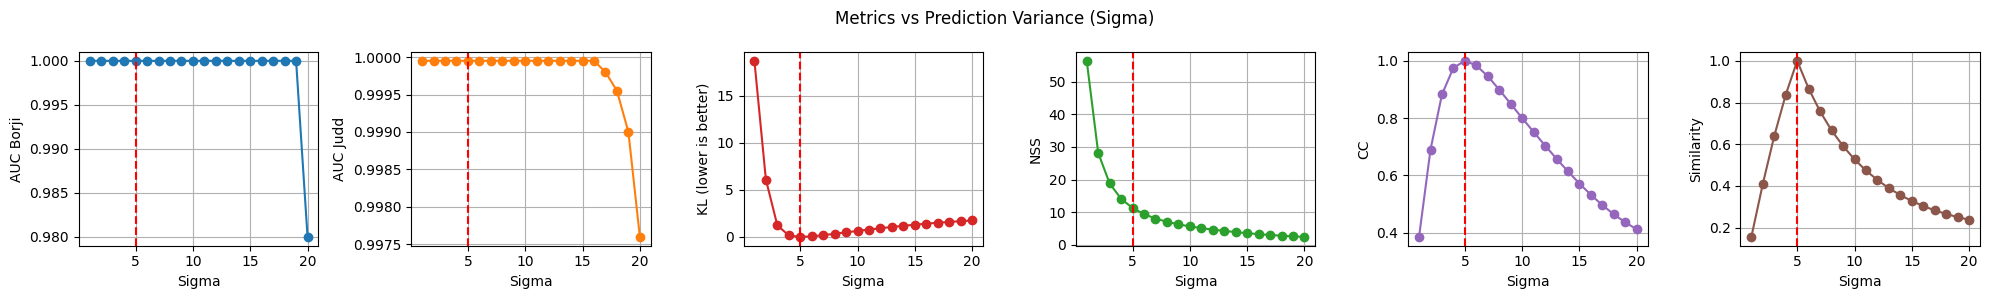

In [12]:
np.random.seed(0)

auc_borji_scores = []
auc_judd_scores = []
kl_scores = []
nss_scores = []
cc_scores = []
sim_scores = []
sigma_values = np.arange(1, 21)  # variance parameters

for s in sigma_values:
    pred = create_examples(100, s, [[25, 25]], [1]) # Q1: Vary prediction variance and evaluate metrics vs sigma
    
    auc_b, _, _ = AUC_Borji(pred, gt_fix_1, Nsplits=50, stepSize=0.01) # gt1: saliency GT, and gt_fix_1: fixation GT
    auc_j, _, _ = AUC_Judd(pred, gt_fix_1, jitter=False)
    kl = kl_divergence(pred, gt1)
    nss = NSS(pred, gt_fix_1)
    cc = CC(pred, gt1)
    sim = similarity(pred, gt1)

    auc_borji_scores.append(auc_b)
    auc_judd_scores.append(auc_j)
    kl_scores.append(kl)
    nss_scores.append(nss)
    cc_scores.append(cc)
    sim_scores.append(sim)


fig, axes = plt.subplots(1,6, figsize=(20, 3))

axes[0].plot(sigma_values, auc_borji_scores, marker='o')
axes[0].axvline(x=5, color='red', linestyle='--', label='GT sigma')
axes[0].set_xlabel('Sigma')
axes[0].set_ylabel('AUC Borji')
axes[0].grid()

axes[1].plot(sigma_values, auc_judd_scores, marker='o', color='tab:orange')
axes[1].axvline(x=5, color='red', linestyle='--', label='GT sigma')
axes[1].set_xlabel('Sigma')
axes[1].set_ylabel('AUC Judd')
axes[1].grid()

axes[2].plot(sigma_values, kl_scores, marker='o', color='tab:red')
axes[2].axvline(x=5, color='red', linestyle='--', label='GT sigma')
axes[2].set_xlabel('Sigma')
axes[2].set_ylabel('KL (lower is better)')
axes[2].grid()

axes[3].plot(sigma_values, nss_scores, marker='o', color='tab:green')
axes[3].axvline(x=5, color='red', linestyle='--', label='GT sigma')
axes[3].set_xlabel('Sigma')
axes[3].set_ylabel('NSS')
axes[3].grid()

axes[4].plot(sigma_values, cc_scores, marker='o', color='tab:purple')
axes[4].axvline(x=5, color='red', linestyle='--', label='GT sigma')
axes[4].set_xlabel('Sigma')
axes[4].set_ylabel('CC')
axes[4].grid()

axes[5].plot(sigma_values, sim_scores, marker='o', color='tab:brown')
axes[5].axvline(x=5, color='red', linestyle='--', label='GT sigma')
axes[5].set_xlabel('Sigma')
axes[5].set_ylabel('Similarity')
axes[5].grid()

plt.suptitle('Metrics vs Prediction Variance (Sigma)')
fig.tight_layout()
plt.show()


C:\Users\Marie\AppData\Local\Temp\ipykernel_16928\993662600.py:56: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc[s] = np.trapz(tpr, x=fpr)
C:\Users\Marie\AppData\Local\Temp\ipykernel_16928\1177653645.py:77: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  score = np.trapz(tpr, x=fpr)


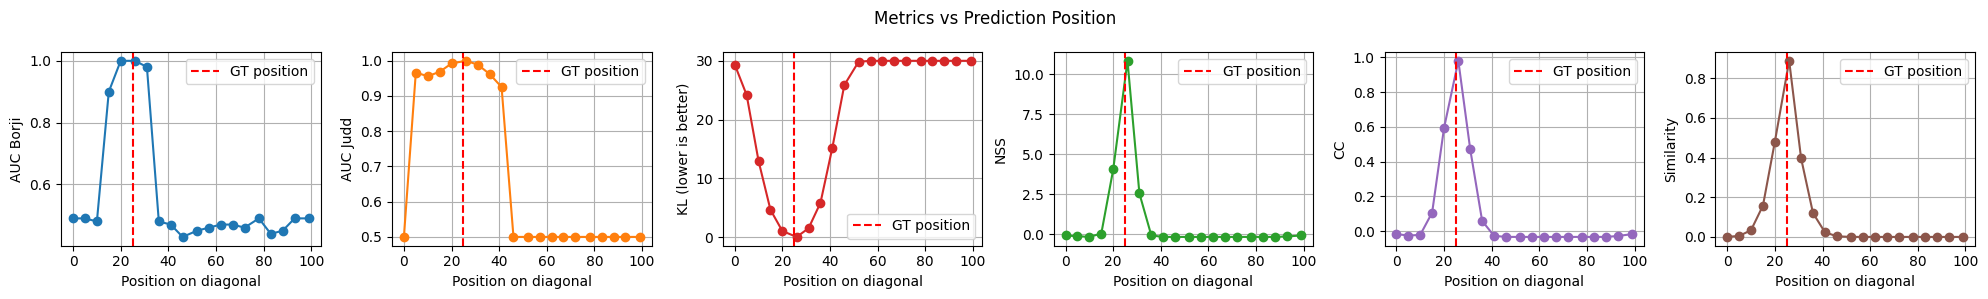

In [13]:
auc_borji_scores_2 = []
auc_judd_scores_2 = []
kl_scores_2 = []
nss_scores_2 = []
cc_scores_2 = []
sim_scores_2 = []
diagonal_positions = np.linspace(0, 99, 20, dtype=int)

for pos in diagonal_positions:
    pred = create_examples(100, 5, [[pos, pos]], [1])
    
    auc_b, _, _ = AUC_Borji(pred, gt_fix_1, Nsplits=50, stepSize=0.01)
    auc_j, _, _ = AUC_Judd(pred, gt_fix_1, jitter=False)
    kl = kl_divergence(pred, gt1)
    nss = NSS(pred, gt_fix_1)
    cc = CC(pred, gt1)
    sim = similarity(pred, gt1)
    
    auc_borji_scores_2.append(auc_b)
    auc_judd_scores_2.append(auc_j)
    kl_scores_2.append(kl)
    nss_scores_2.append(nss)
    cc_scores_2.append(cc)
    sim_scores_2.append(sim)

fig, axes = plt.subplots(1, 6, figsize=(20, 3))

axes[0].plot(diagonal_positions, auc_borji_scores_2, marker='o')
axes[0].axvline(x=25, color='red', linestyle='--', label='GT position')
axes[0].set_xlabel('Position on diagonal')
axes[0].set_ylabel('AUC Borji')
axes[0].grid()
axes[0].legend()

axes[1].plot(diagonal_positions, auc_judd_scores_2, marker='o', color='tab:orange')
axes[1].axvline(x=25, color='red', linestyle='--', label='GT position')
axes[1].set_xlabel('Position on diagonal')
axes[1].set_ylabel('AUC Judd')
axes[1].grid()
axes[1].legend()

axes[2].plot(diagonal_positions, kl_scores_2, marker='o', color='tab:red')
axes[2].axvline(x=25, color='red', linestyle='--', label='GT position')
axes[2].set_xlabel('Position on diagonal')
axes[2].set_ylabel('KL (lower is better)')
axes[2].grid()
axes[2].legend()

axes[3].plot(diagonal_positions, nss_scores_2, marker='o', color='tab:green')
axes[3].axvline(x=25, color='red', linestyle='--', label='GT position')
axes[3].set_xlabel('Position on diagonal')
axes[3].set_ylabel('NSS')
axes[3].grid()
axes[3].legend()

axes[4].plot(diagonal_positions, cc_scores_2, marker='o', color='tab:purple')
axes[4].axvline(x=25, color='red', linestyle='--', label='GT position')
axes[4].set_xlabel('Position on diagonal')
axes[4].set_ylabel('CC')
axes[4].grid()
axes[4].legend()

axes[5].plot(diagonal_positions, sim_scores_2, marker='o', color='tab:brown')
axes[5].axvline(x=25, color='red', linestyle='--', label='GT position')
axes[5].set_xlabel('Position on diagonal')
axes[5].set_ylabel('Similarity')
axes[5].grid()
axes[5].legend()

plt.suptitle('Metrics vs Prediction Position')
fig.tight_layout()
plt.show()

**Analysis :**

When sigma matches the GT, KL is lowest and NSS/CC/SIM peak. When the sigma is too small, it makes over-sharp maps (KL/NSS/SIM drops severely) and when the sigma is too large, it over-smooths and all scores fall. AUC Borji/Judd stay really high and flat except at extremes, showing they tolerate variance as long as the peak still covers the fixation.

NSS, CC, and SIM are very sensitive to spatial location and heavily penalize position errors even when the variance is correct. AUC Borji/Judd also separate positions well, confirming their usefulness for evaluating fixation prediction.

With the second ground-truth, we will observe what happens when a prediction moves between two correct attention clusters, and what happens when the relative weights between the two clusters vary.

#### 3) Similarly, create "predictions" with only one point moving on the main diagonal, between the first and second cluster. Plot the evolution curve for each metric.

#### 4) Do the same by moving the relative weights of the two clusters, and comment your results.

C:\Users\Marie\AppData\Local\Temp\ipykernel_16928\993662600.py:56: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc[s] = np.trapz(tpr, x=fpr)
C:\Users\Marie\AppData\Local\Temp\ipykernel_16928\1177653645.py:77: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  score = np.trapz(tpr, x=fpr)


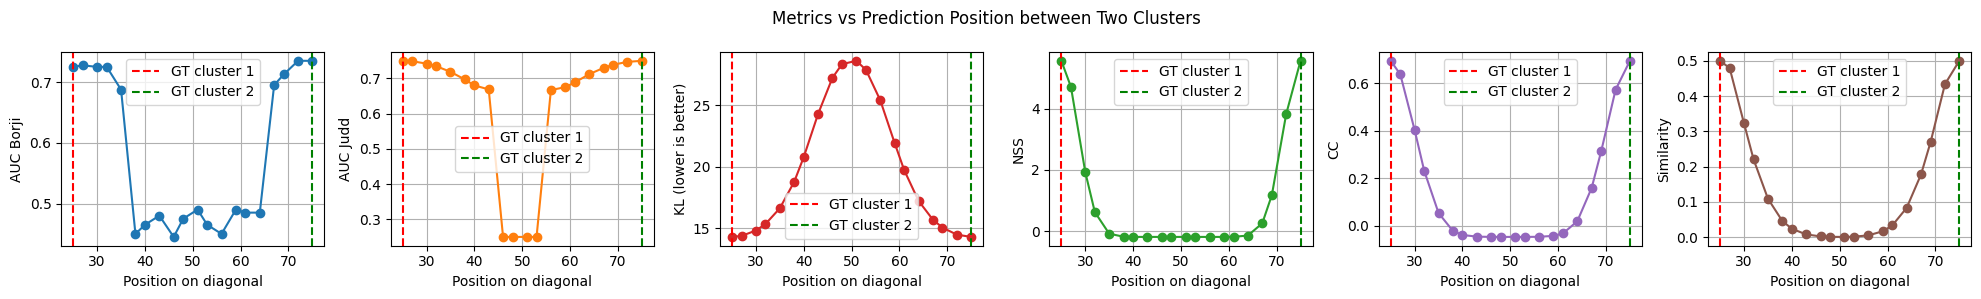

In [14]:
positions_3 = np.linspace(25, 75, 20, dtype=int)

auc_borji_scores_3 = []
auc_judd_scores_3 = []
kl_scores_3 = []
nss_scores_3 = []
cc_scores_3 = []
sim_scores_3 = []

for pos in positions_3:
    pred = create_examples(100, 5, [[pos, pos]], [1])  # single point moving between clusters
    
    auc_b, _, _ = AUC_Borji(pred, gt_fix_2, Nsplits=50, stepSize=0.01)
    auc_j, _, _ = AUC_Judd(pred, gt_fix_2, jitter=False)
    kl = kl_divergence(pred, gt2)
    nss = NSS(pred, gt_fix_2)
    cc = CC(pred, gt2)
    sim = similarity(pred, gt2)
    
    auc_borji_scores_3.append(auc_b)
    auc_judd_scores_3.append(auc_j)
    kl_scores_3.append(kl)
    nss_scores_3.append(nss)
    cc_scores_3.append(cc)
    sim_scores_3.append(sim)

fig, axes = plt.subplots(1,6, figsize=(20, 3))

axes[0].plot(positions_3, auc_borji_scores_3, marker='o')
axes[0].axvline(x=25, color='red', linestyle='--', label='GT cluster 1')
axes[0].axvline(x=75, color='green', linestyle='--', label='GT cluster 2')
axes[0].set_xlabel('Position on diagonal')
axes[0].set_ylabel('AUC Borji')
axes[0].grid()
axes[0].legend()

axes[1].plot(positions_3, auc_judd_scores_3, marker='o', color='tab:orange')
axes[1].axvline(x=25, color='red', linestyle='--', label='GT cluster 1')
axes[1].axvline(x=75, color='green', linestyle='--', label='GT cluster 2')
axes[1].set_xlabel('Position on diagonal')
axes[1].set_ylabel('AUC Judd')
axes[1].grid()
axes[1].legend()

axes[2].plot(positions_3, kl_scores_3, marker='o', color='tab:red')
axes[2].axvline(x=25, color='red', linestyle='--', label='GT cluster 1')
axes[2].axvline(x=75, color='green', linestyle='--', label='GT cluster 2')
axes[2].set_xlabel('Position on diagonal')
axes[2].set_ylabel('KL (lower is better)')
axes[2].grid()
axes[2].legend()

axes[3].plot(positions_3, nss_scores_3, marker='o', color='tab:green')
axes[3].axvline(x=25, color='red', linestyle='--', label='GT cluster 1')
axes[3].axvline(x=75, color='green', linestyle='--', label='GT cluster 2')
axes[3].set_xlabel('Position on diagonal')
axes[3].set_ylabel('NSS')
axes[3].grid()
axes[3].legend()

axes[4].plot(positions_3, cc_scores_3, marker='o', color='tab:purple')
axes[4].axvline(x=25, color='red', linestyle='--', label='GT cluster 1')
axes[4].axvline(x=75, color='green', linestyle='--', label='GT cluster 2')
axes[4].set_xlabel('Position on diagonal')
axes[4].set_ylabel('CC')
axes[4].grid()
axes[4].legend()

axes[5].plot(positions_3, sim_scores_3, marker='o', color='tab:brown')
axes[5].axvline(x=25, color='red', linestyle='--', label='GT cluster 1')
axes[5].axvline(x=75, color='green', linestyle='--', label='GT cluster 2')
axes[5].set_xlabel('Position on diagonal')
axes[5].set_ylabel('Similarity')
axes[5].grid()
axes[5].legend()

plt.suptitle('Metrics vs Prediction Position between Two Clusters')
fig.tight_layout()
plt.show()

C:\Users\Marie\AppData\Local\Temp\ipykernel_16928\993662600.py:56: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc[s] = np.trapz(tpr, x=fpr)
C:\Users\Marie\AppData\Local\Temp\ipykernel_16928\1177653645.py:77: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  score = np.trapz(tpr, x=fpr)


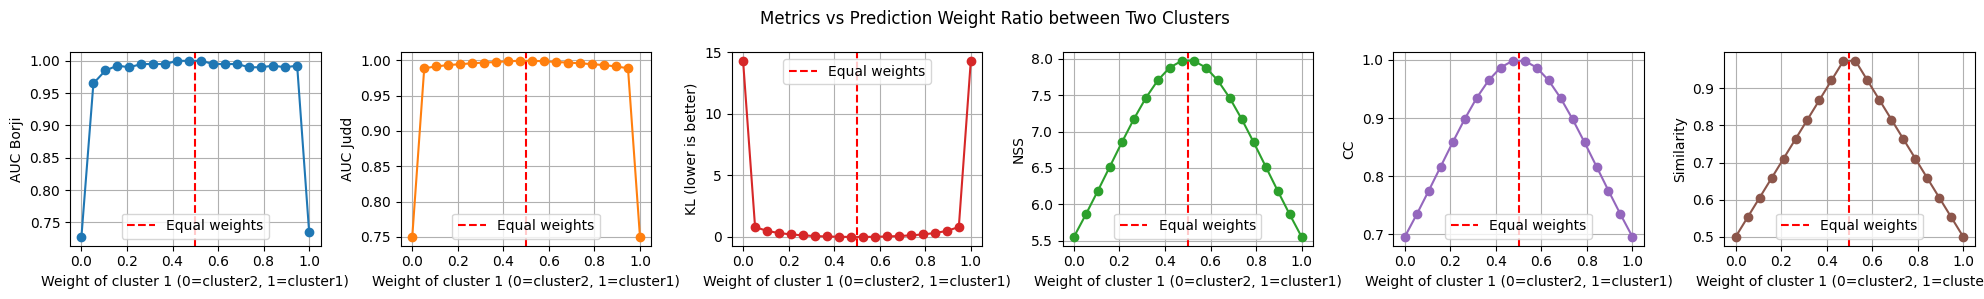

In [15]:
weight_ratios = np.linspace(0, 1, 20)

auc_borji_scores_4 = []
auc_judd_scores_4 = []
kl_scores_4 = []
nss_scores_4 = []
cc_scores_4 = []
sim_scores_4 = []

for w1 in weight_ratios:
    w2 = 1 - w1
    pred = create_examples(100, 5, [[25, 25], [75, 75]], [w1, w2])
    
    auc_b, _, _ = AUC_Borji(pred, gt_fix_2, Nsplits=50, stepSize=0.01)
    auc_j, _, _ = AUC_Judd(pred, gt_fix_2, jitter=False)
    kl = kl_divergence(pred, gt2)
    nss = NSS(pred, gt_fix_2)
    cc = CC(pred, gt2)
    sim = similarity(pred, gt2)
    
    auc_borji_scores_4.append(auc_b)
    auc_judd_scores_4.append(auc_j)
    kl_scores_4.append(kl)
    nss_scores_4.append(nss)
    cc_scores_4.append(cc)
    sim_scores_4.append(sim)

fig, axes = plt.subplots(1,6, figsize=(20, 3))

axes[0].plot(weight_ratios, auc_borji_scores_4, marker='o')
axes[0].axvline(x=0.5, color='red', linestyle='--', label='Equal weights')
axes[0].set_xlabel('Weight of cluster 1 (0=cluster2, 1=cluster1)')
axes[0].set_ylabel('AUC Borji')
axes[0].grid()
axes[0].legend()

axes[1].plot(weight_ratios, auc_judd_scores_4, marker='o', color='tab:orange')
axes[1].axvline(x=0.5, color='red', linestyle='--', label='Equal weights')
axes[1].set_xlabel('Weight of cluster 1 (0=cluster2, 1=cluster1)')
axes[1].set_ylabel('AUC Judd')
axes[1].grid()
axes[1].legend()

axes[2].plot(weight_ratios, kl_scores_4, marker='o', color='tab:red')
axes[2].axvline(x=0.5, color='red', linestyle='--', label='Equal weights')
axes[2].set_xlabel('Weight of cluster 1 (0=cluster2, 1=cluster1)')
axes[2].set_ylabel('KL (lower is better)')
axes[2].grid()
axes[2].legend()

axes[3].plot(weight_ratios, nss_scores_4, marker='o', color='tab:green')
axes[3].axvline(x=0.5, color='red', linestyle='--', label='Equal weights')
axes[3].set_xlabel('Weight of cluster 1 (0=cluster2, 1=cluster1)')
axes[3].set_ylabel('NSS')
axes[3].grid()
axes[3].legend()

axes[4].plot(weight_ratios, cc_scores_4, marker='o', color='tab:purple')
axes[4].axvline(x=0.5, color='red', linestyle='--', label='Equal weights')
axes[4].set_xlabel('Weight of cluster 1 (0=cluster2, 1=cluster1)')
axes[4].set_ylabel('CC')
axes[4].grid()
axes[4].legend()

axes[5].plot(weight_ratios, sim_scores_4, marker='o', color='tab:brown')
axes[5].axvline(x=0.5, color='red', linestyle='--', label='Equal weights')
axes[5].set_xlabel('Weight of cluster 1 (0=cluster2, 1=cluster1)')
axes[5].set_ylabel('Similarity')
axes[5].grid()
axes[5].legend()

plt.suptitle('Metrics vs Prediction Weight Ratio between Two Clusters')
fig.tight_layout()
plt.show()

**Analysis with moving point :**

- AUC Borji/Judd: high near either cluster (peak covers one fixation), dropping in the middle
- KL: lowest when the peak sits on a GT cluster; highest in the middle (far from both GT peaks)
- NSS, CC and SIM: highest on a cluster (high at one fixation, low at the other) and sharp drop between clusters

All metrics favor exact alignment with one attention pole and penalize the midpoint that matches neither GT peak.

**Analysis for the weight :**

- AUC Borji/Judd: flat plateau. Largely insensitive to the weight ratio. They compare saliency at each fixation independently as long as both peaks exist, scores stay high
- KL, NSS, CC, SIM: peaks at 0.5 (equal weights), sensitive to imbalance. Scores drop as one cluster dominates, these metrics measure distributional agreement

AUC-based metrics are robust to imbalance and good for fixation validation; distribution metrics penalize imbalance and better assess full saliency distributions.